In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, pickle
import sys
from skimage import io
import os

sys.path.append("../../")


%load_ext autoreload
%autoreload 2
%matplotlib inline

 This notebook:
 * Load and print the performance saved in /basedir/model_name/pd_summary.csv ,
 * Plot the output images saved in  /basedir/model_name/output_images/
 * Plot the losses in /basedir/model_name/history.json


In [3]:
from dataprocessing.dataloaders import ImageBlindSpotDataset

## This should be the file where the .npz data is:: !!!
data_dir = '/home/natalia/ImPartial/Data/MIBI_2CH/' ## This should be the file where the .npz data is
scribbles = '150'

pd_files = pd.read_csv(data_dir+'files.csv',index_col=0)
print(pd_files)

files_scribbles = data_dir + 'files_2tasks1x2classes_3images_scribble_train_' + scribbles + '.csv'
pd_files_scribbles = pd.read_csv(files_scribbles)

print()
print('Total images  train: ', len(pd_files_scribbles),'; test: ', len(pd_files)-len(pd_files_scribbles) )
pd_files_scribbles

   prefix                               input_dir  input_file  group
0  image0  /home/natalia/ImPartial/Data/MIBI_2CH/  image0.npz  train
1  image1  /home/natalia/ImPartial/Data/MIBI_2CH/  image1.npz  train
2  image2  /home/natalia/ImPartial/Data/MIBI_2CH/  image2.npz   test
3  image3  /home/natalia/ImPartial/Data/MIBI_2CH/  image3.npz  train

Total images  train:  3 ; test:  1


,input_dir,input_file,prefix,scribble_file,total_labels_class0,scribble_labels_class0,label_with_scribble_class0,perc_pixels_scribbles_TP_class0,perc_pixels_scribbles_TN_class0,total_labels_class1,...,label_with_scribble_class1,perc_pixels_scribbles_TP_class1,perc_pixels_scribbles_TN_class1,total_labels_class2,scribble_labels_class2,label_with_scribble_class2,perc_pixels_scribbles_TP_class2,perc_pixels_scribbles_TN_class2,gt_index_task0,gt_index_task1
0,/home/natalia/ImPartial/Data/MIBI_2CH/,image0.npz,image0,image0_2tasks1x2classes_3images_scribble_n150.npz,160,23,[ 1 5 6 9 10 13 20 26 27 34 41 ...,2.14,3.87,152,...,[ 3 5 16 19 34 36 37 49 55 62 63 ...,0.42,0.92,20,12,[ 1 3 5 6 8 9 13 14 15 16 17 18],6.01,0.49,[0],"[1, 2]"
1,/home/natalia/ImPartial/Data/MIBI_2CH/,image1.npz,image1,image1_2tasks1x2classes_3images_scribble_n150.npz,72,20,[ 2 3 4 14 16 18 21 24 29 37 48 54 60 63 67 ...,4.24,1.86,61,...,[ 4 7 10 15 16 18 20 23 26 29 30 31 47 48 54 ...,0.70,1.03,49,11,[ 3 5 6 8 13 14 25 45 46 48 49],1.49,0.46,[0],"[1, 2]"
2,/home/natalia/ImPartial/Data/MIBI_2CH/,image3.npz,image3,image3_2tasks1x2classes_3images_scribble_n150.npz,62,22,[ 1 8 12 18 23 24 25 26 27 28 29 31 44 48 49 ...,7.12,2.16,47,...,[ 9 10 11 12 14 15 17 23 26 28 30 31 33 34 36 41],1.28,0.80,122,14,[24 26 27 29 32 49 51 52 53 54 55 56 59 65],0.44,0.71,[0],"[1, 2]"


### Print Summary Results

In [9]:
from general.utils import mkdir,load_json
basedir = '/data/natalia/models/MIBI2CH/s150/Impartial/'
model_name = 'Im_2tasks_base64depth4relu_adam5e4_nsave5_segCEGauss_w04501_seed42'
pd_summary = pd.read_csv(basedir+model_name+'/pd_summary_results.csv')


from general.evaluation import summary_performance
pd_best = summary_performance(pd_summary, best_all = False, metric = 'AP', group = 'train')
pd_best_all = summary_performance(pd_summary, best_all = True)

print('**** Model selection based on AP on training : ')
print(pd_best.groupby(['task','segclass','group']).mean())
print()
print('------------------------------')
print()
print('**** Best of all Model selection: ')
print(pd_best_all.groupby(['task','segclass','group']).mean())

**** Model selection based on AP on training : 
                       th       auc      Jacc      mIoU     mDice        AP
task segclass group                                                        
0    0        test   0.65  0.967376  0.654965  0.525729  0.662511  0.218182
              train  0.65  0.956868  0.702505  0.575155  0.696980  0.417268
1    0        test   0.20  0.959437  0.606078  0.593370  0.727117  0.472222
              train  0.20  0.955396  0.645910  0.649113  0.776185  0.637947
     1        test   0.25  0.989174  0.715383  0.562778  0.686147  0.367816
              train  0.25  0.977665  0.654299  0.634061  0.755039  0.553869

------------------------------

**** Best of all Model selection: 
                       th       auc      Jacc      mIoU     mDice        AP
task segclass group                                                        
0    0        test   0.95  0.967376  0.700649  0.525729  0.662511  0.252427
              train  0.95  0.956868  0.759883  0

### Plot Output Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Image/Group ::  image0.npz / train

Task :  0  nclasses : 1

Class  0


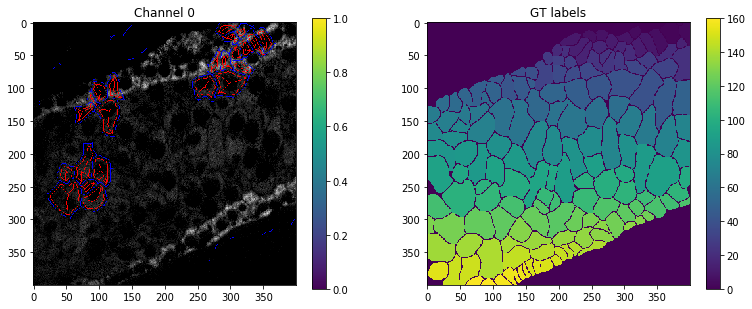

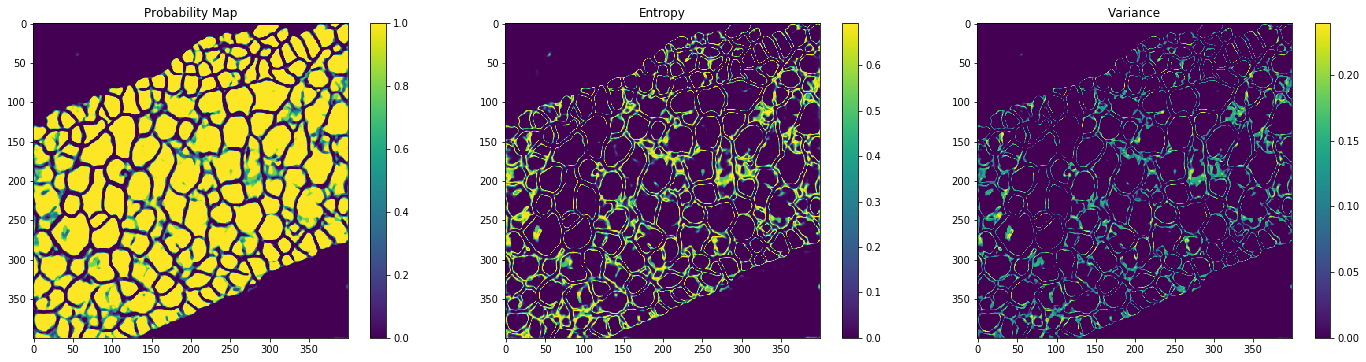

Task :  1  nclasses : 2

Class  0


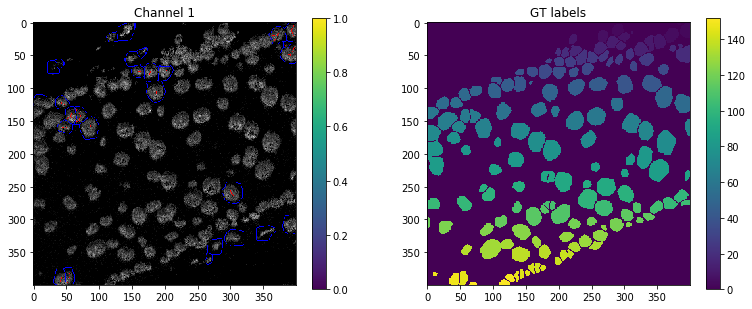

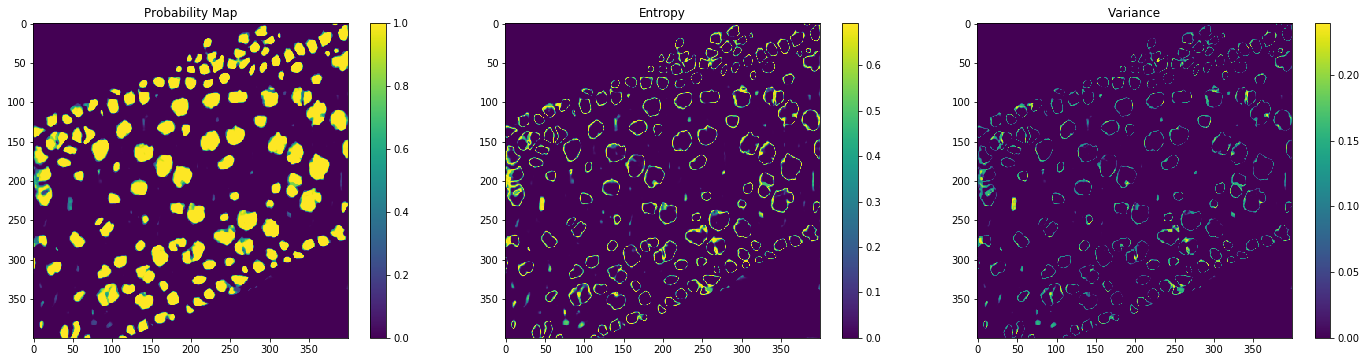

Class  1


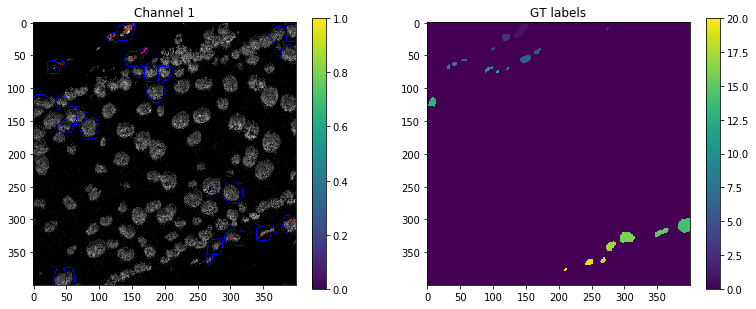

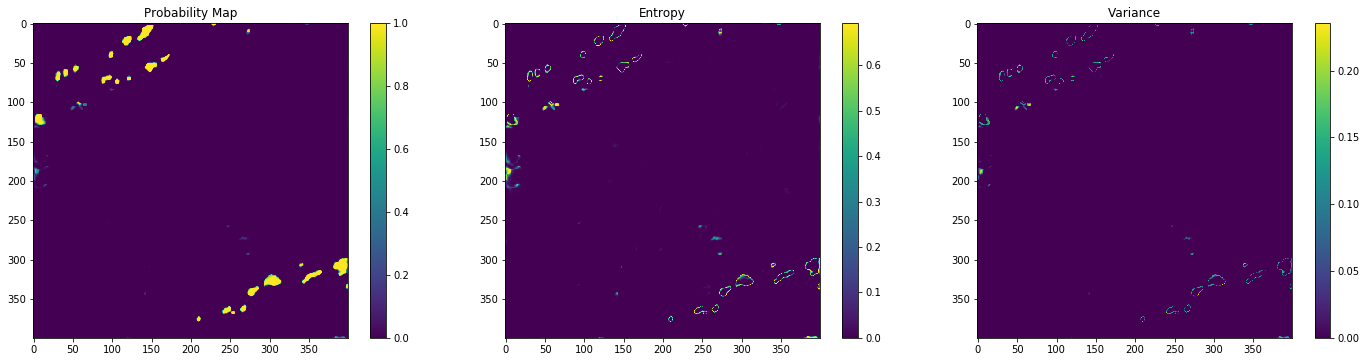

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----------------

Image/Group ::  image1.npz / train

Task :  0  nclasses : 1

Class  0


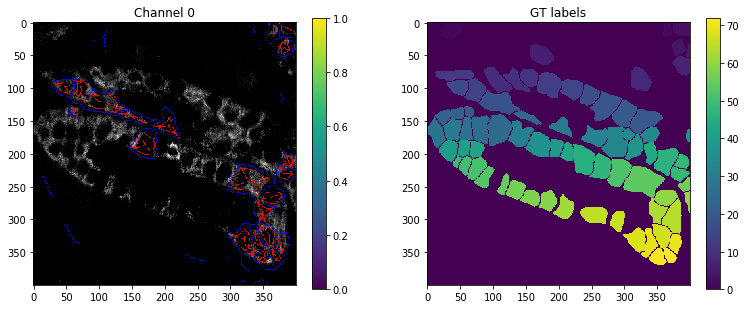

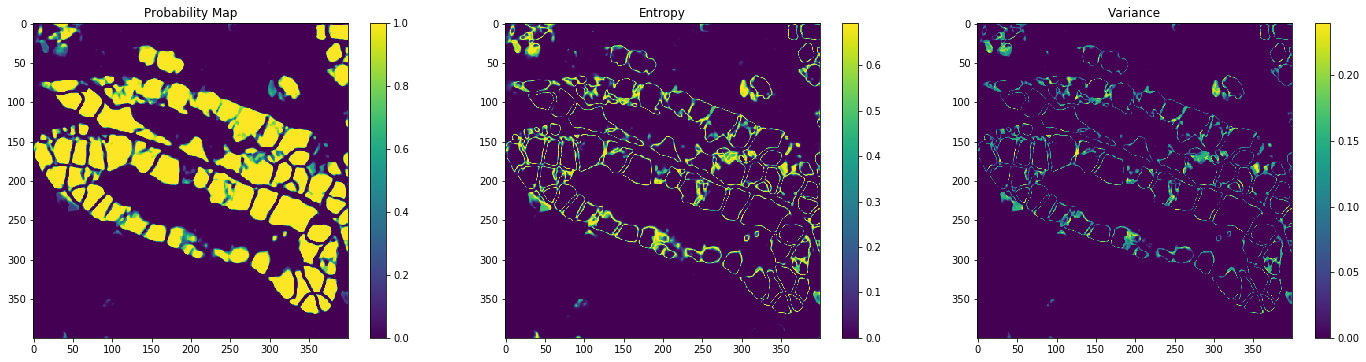

Task :  1  nclasses : 2

Class  0


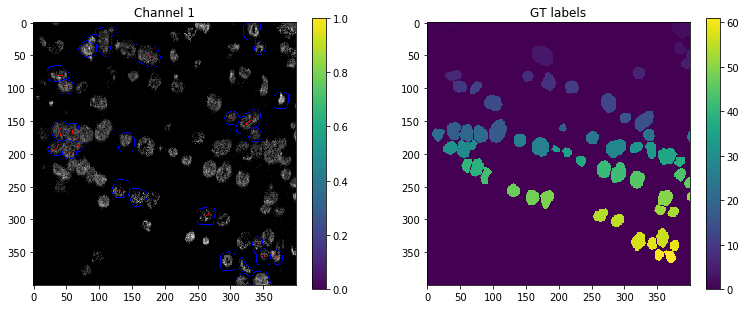

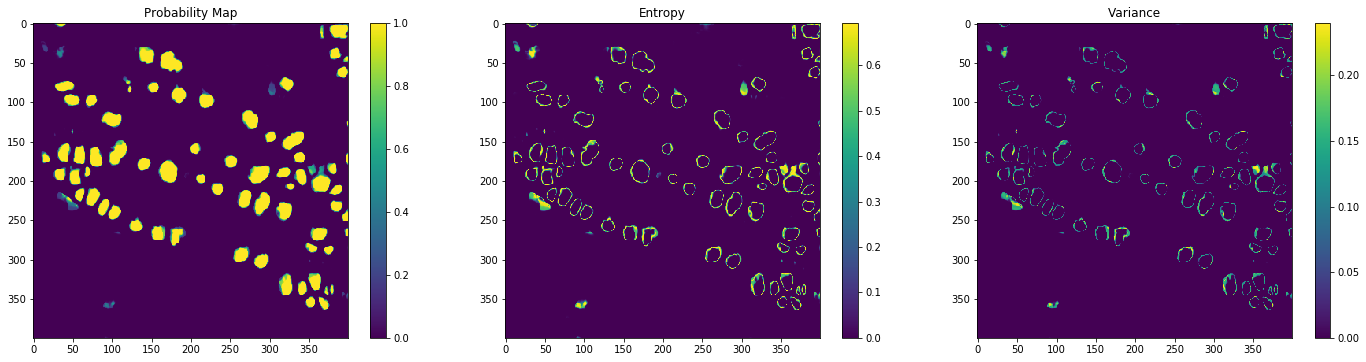

Class  1


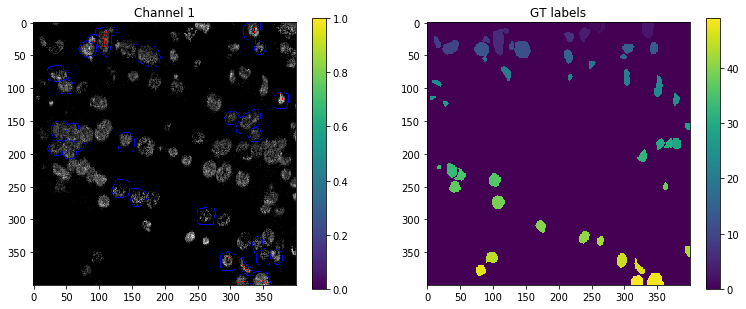

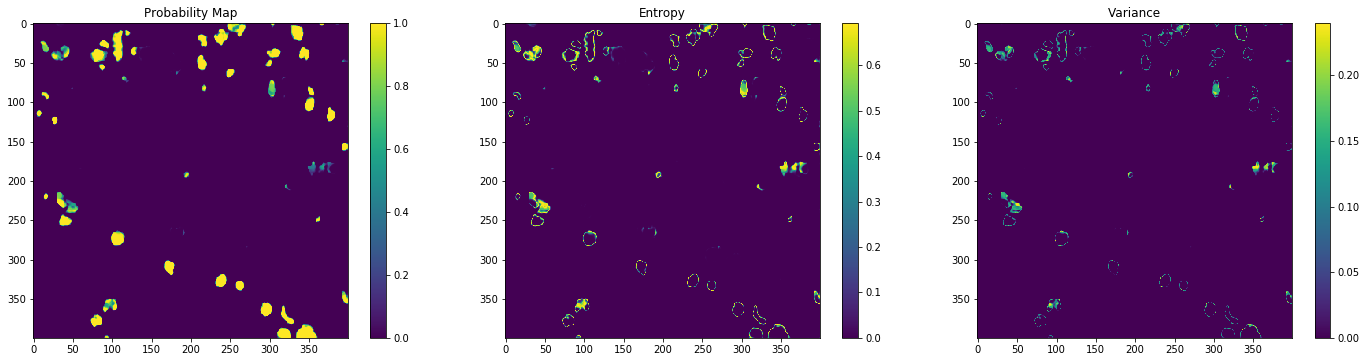

----------------

Image/Group ::  image2.npz / test

Task :  0  nclasses : 1

Class  0


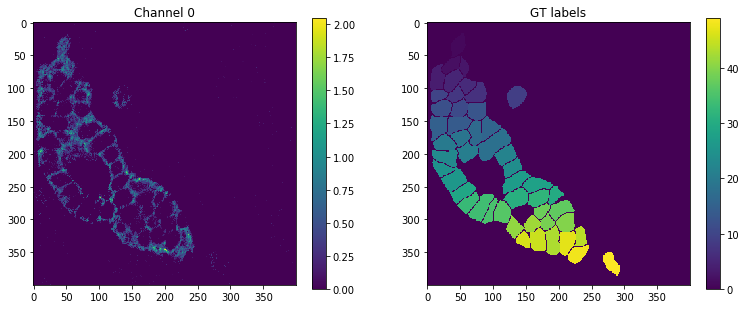

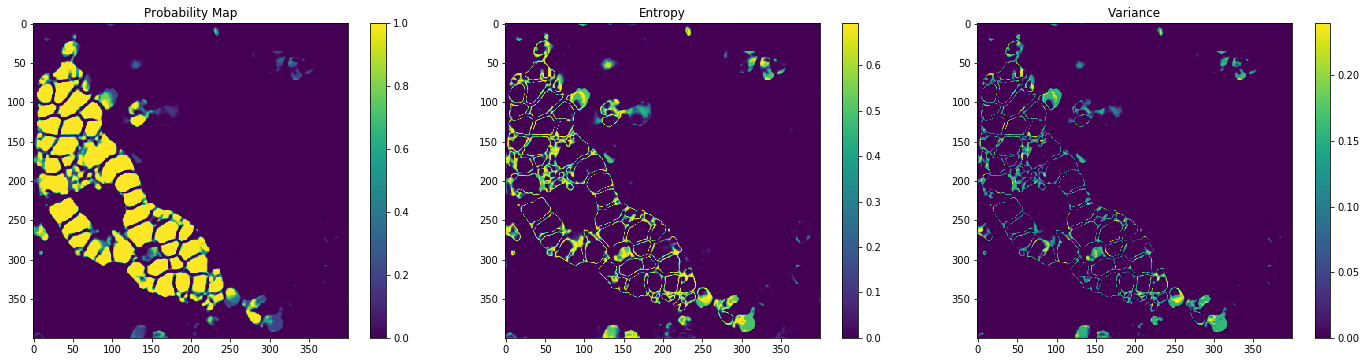

Task :  1  nclasses : 2

Class  0


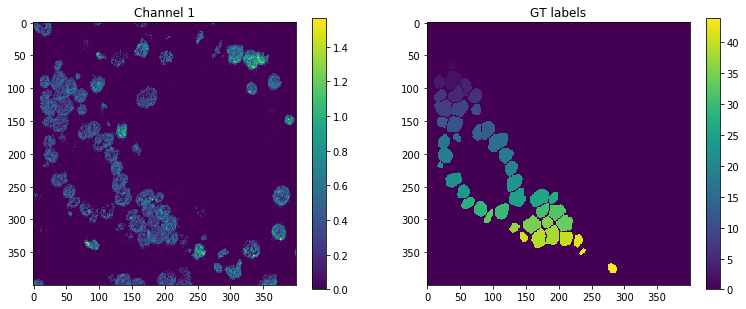

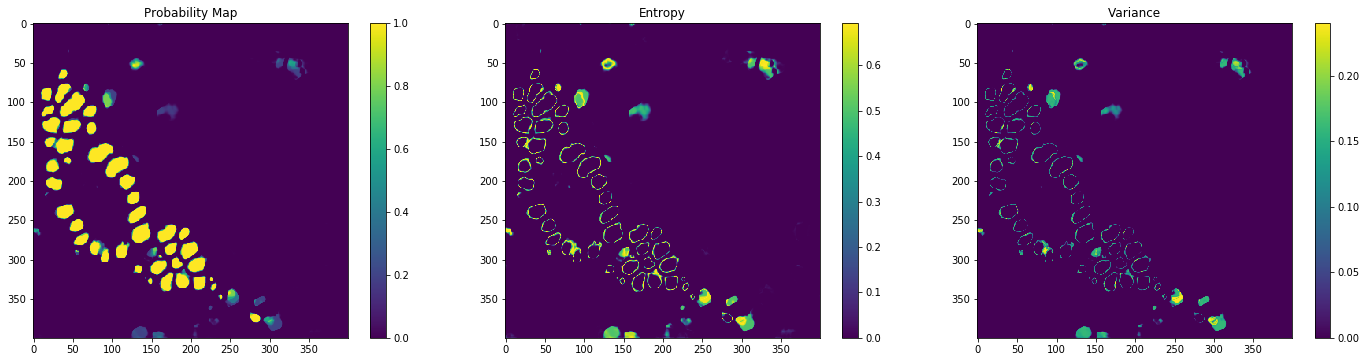

Class  1


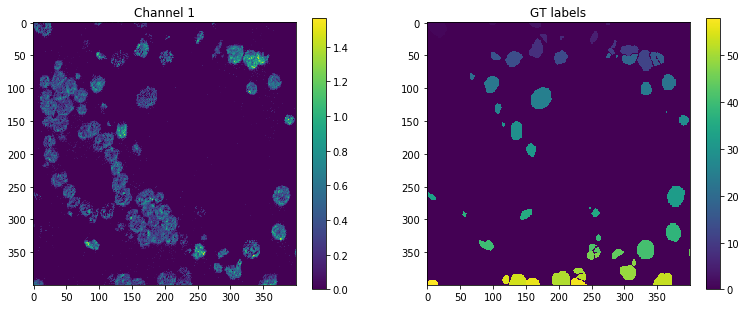

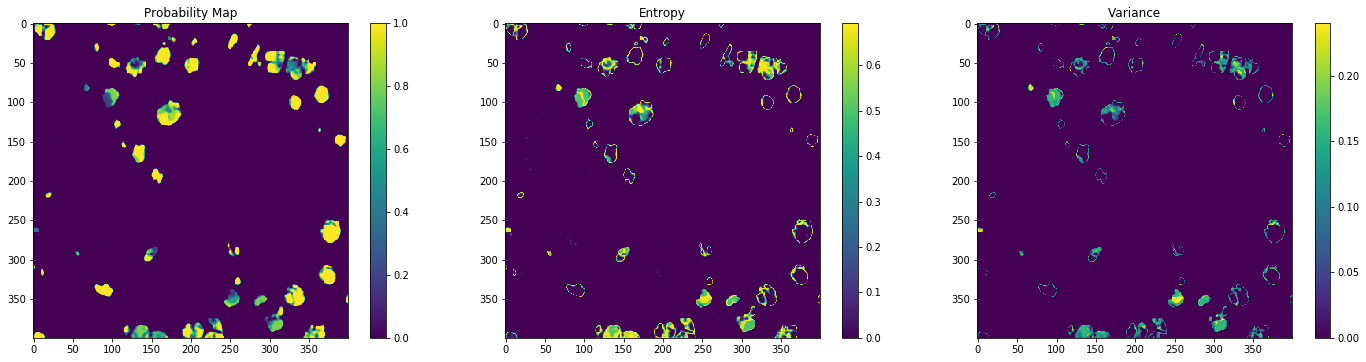

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----------------

Image/Group ::  image3.npz / train

Task :  0  nclasses : 1

Class  0


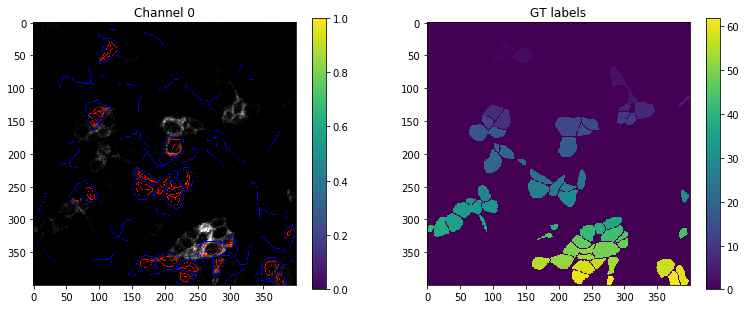

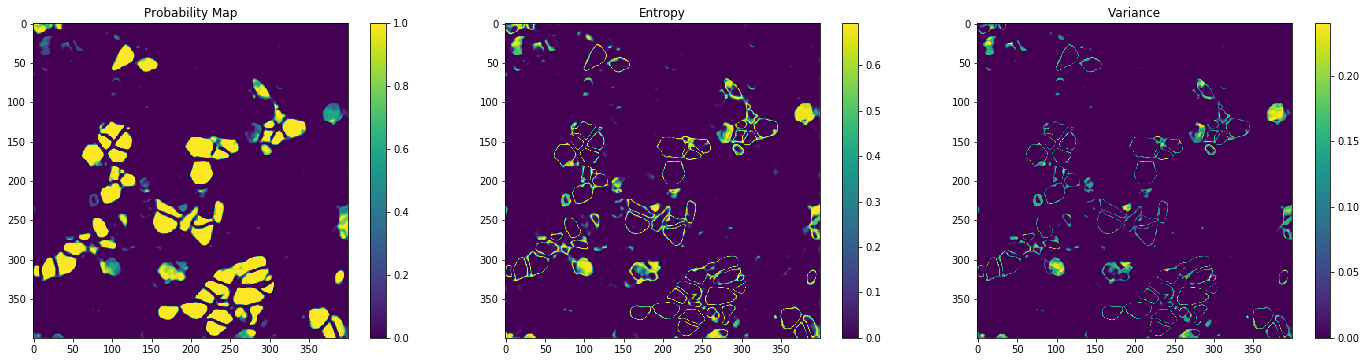

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Task :  1  nclasses : 2

Class  0


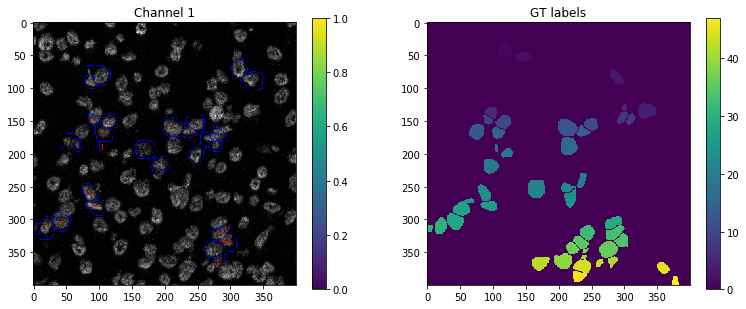

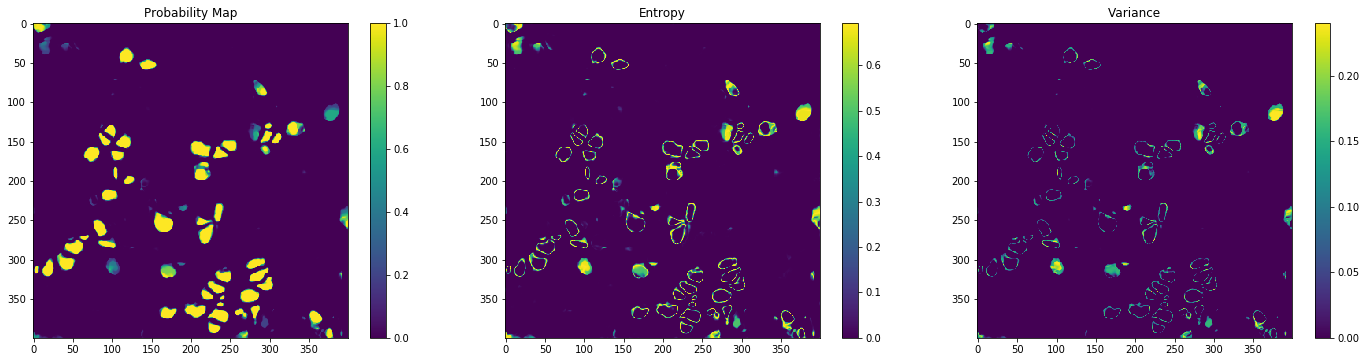

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class  1


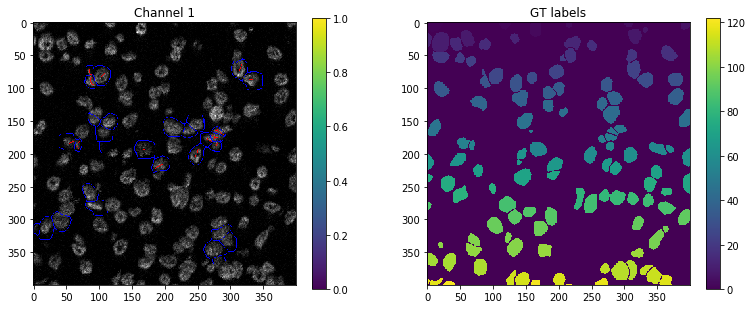

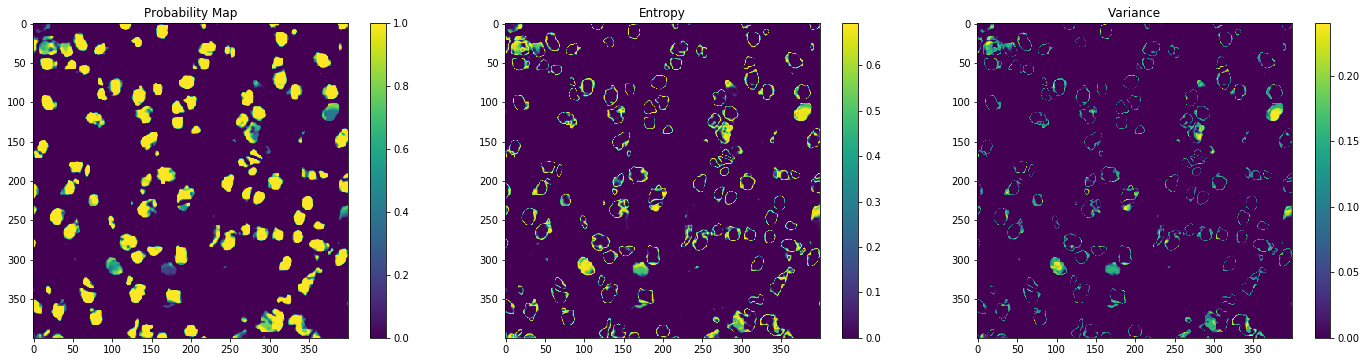

----------------


In [46]:
from general.utils import load_json
config_json = load_json(basedir + model_name + '/config.json')
pd_output_saves = pd.read_csv(basedir+model_name+'/output_images/pd_output_saves.csv')

for ix_file in range(len(pd_files)):
    print()
    print('Image/Group :: ',pd_files['input_file'][ix_file],'/',pd_files['group'][ix_file] )
    print()
    npz_read = np.load(pd_files['input_dir'][ix_file] + pd_files['input_file'][ix_file])
    image = npz_read['image']
    label = npz_read['label']
    
    prefix = pd_files['prefix'][ix_file]
    output_file = pd_output_saves.loc[(pd_output_saves.prefix == prefix)]['output_file'].values[0]
    
    with open(basedir+model_name+'/output_images/'+output_file, 'rb') as file_name:
        #output is a dictionary with tasks as keys (in this case 0 and 1)
        #each output[task] is a dictionary with:
        #   'class_segmentation': np.array size batchxnclassesxhxw, 
        #   'class_segmentation_variance': np.array size batchxnclassesxhxw
        output = pickle.load(file_name) 

    if pd_files['group'][ix_file] == 'train':
        pd_scribble = pd_files_scribbles.loc[pd_files_scribbles['prefix'] == pd_files['prefix'][ix_file]]
        npz_read = np.load(pd_scribble['input_dir'].values[0] + pd_scribble['scribble_file'].values[0])
        scribble = npz_read['scribble']

    ix_scribbles = 0
    for task in output.keys():
        
        # get list of corresponding gt indexes to plot
        ix_labels_list = config_json['classification_tasks'][task]['ix_gt_labels']
        rec_channels = config_json['classification_tasks'][task]['rec_channels']
        nclasses = output[task]['class_segmentation'].shape[1]
        
        print('Task : ',task, ' nclasses :',nclasses )
        print()
        for ix_class in range(nclasses):
            print('Class ', ix_class)
            ix_labels = int(ix_labels_list[ix_class])
            plt.figure(figsize=(20,5))
            plt.subplot(1,3,1)
            
            if pd_files['group'][ix_file] == 'train':
                aux = np.ones([image.shape[0],image.shape[1],3])*image[...,rec_channels[0]][...,np.newaxis]*0.6
                aux = aux*(1-scribble[...,ix_scribbles+nclasses][...,np.newaxis])
                aux[...,2] += scribble[...,ix_scribbles+nclasses]
    
                aux = aux*(1-scribble[...,ix_scribbles+ix_class])[...,np.newaxis]
                aux[...,0] += scribble[...,ix_scribbles+ix_class]
                
                plt.imshow(aux)
            else:
                plt.imshow(image[...,rec_channels[0]])
            plt.title('Channel '+ str(rec_channels[0]))
            plt.colorbar()

            plt.subplot(1,3,2)
            plt.title('GT labels')
            plt.imshow(label[...,ix_labels])
            ix_labels += 1
            plt.colorbar()
#             plt.tight_layout()
            plt.show()

            plt.figure(figsize=(20,5))
            plt.subplot(1,3,1)
            plt.title('Probability Map')
            plt.imshow((output[task]['class_segmentation'][0,ix_class,...]))
            plt.colorbar()
            
            plt.subplot(1,3,2)
            plt.title('Entropy')
            entropy = -output[task]['class_segmentation'][0,ix_class,...]*np.log(np.maximum(output[task]['class_segmentation'][0,ix_class,...],1e-5))
            entropy += -(1-output[task]['class_segmentation'][0,ix_class,...])*np.log(np.maximum(1-output[task]['class_segmentation'][0,ix_class,...],1e-5))
            plt.imshow(entropy)
            plt.colorbar()
            
            if 'class_segmentation_variance' in output[task].keys():
                plt.subplot(1,3,3)
                plt.title('Variance')
                plt.imshow((output[task]['class_segmentation_variance'][0,ix_class,...]))
                plt.colorbar()
            
            plt.tight_layout()
            plt.show()
        
        ix_scribbles += nclasses + 1
    print('----------------')

### Plot Losses

Model : Im_2tasks_base64depth4relu_adam5e4_nsave5_segCEGauss_w04501_seed42 ; scribbles :  150


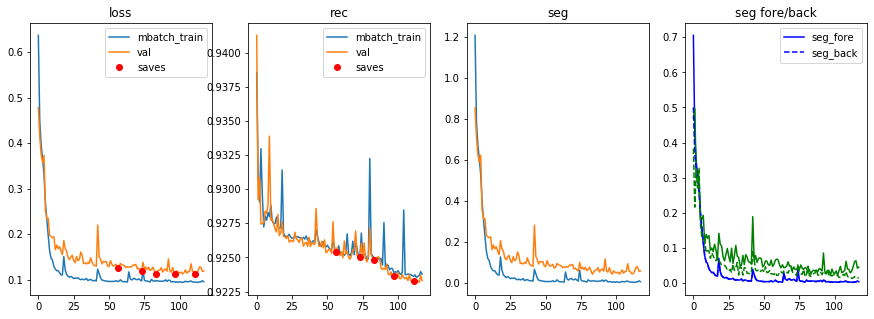

In [47]:
## Plot losses:
history = load_json(basedir + model_name + '/history.json')
config_json = load_json(basedir + model_name + '/config.json')
val_epochs_save = np.array(history['val_epochs_saves_list']).astype('int')

print('Model :', model_name, '; scribbles : ',scribbles)

tag = 'loss'
plt.figure(figsize=(15,5))
ix = 1
for tag in ['loss','rec']:
    plt.subplot(1,4,ix)
    ix += 1
    if tag+'_mbatch_train' in history.keys():
        plt.title(tag)
        plt.plot(history[tag+'_mbatch_train'],label='mbatch_train')
        plt.plot(history[tag+'_val'],label='val')
        plt.plot(val_epochs_save,np.array(history[tag+'_val'])[val_epochs_save],'ro',label='saves')
        plt.legend()
plt.subplot(1,4,ix)
ix += 1
plt.title('seg')
plt.plot(np.array(history['seg_fore_mbatch_train']) + np.array(history['seg_back_mbatch_train']) )
plt.plot(np.array(history['seg_fore_val'])+ np.array(history['seg_back_val']))

plt.subplot(1,4,ix)
plt.title('seg fore/back')
pointer = '-'
for tag in ['seg_fore','seg_back']:
    plt.plot(history[tag+'_mbatch_train'],'b'+pointer,label = tag)
    plt.plot(history[tag+'_val'],'g'+pointer)
    pointer = '--'
plt.legend()
plt.show()
